In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
PATH_TO_DATA = '../datasets/porto-seguros-safe-driver-prediction-files'

In [3]:
Xy_all = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), nrows=100000)
X_all = Xy_all.drop(columns=['id','target'])
y_all = Xy_all['target']

In [4]:
cat_cols = [col for col in X_all if col.endswith('_cat')]
X_all[cat_cols] = X_all[cat_cols].astype('category')

cat_cols_coded = []
for col in cat_cols:
    X_all[col + '_coded'] = X_all[col].cat.codes
    cat_cols_coded.append(col+'_coded')
    
other_cols = [col for col in X_all.columns if ((not col in cat_cols) and (not col in cat_cols_coded))]

## Model with embedding

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15)

for train_index, test_index in sss.split(X_all, y_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    y_train, y_test = y_all.iloc[train_index], y_all.iloc[test_index]
    

In [6]:
def create_embedding_model():
    inputs = []
    models = []

    cat_input = Input(shape=(1,))
        
    embedding = Embedding(6 ,10)(cat_input)
    embedding = Reshape(target_shape=(10,))(embedding)
        
    inputs.append(cat_input)
    models.append(embedding)
    
    other_input = Input(shape=(43,), name='other')
    other_model = Dense(20, activation='relu', kernel_constraint=max_norm(4.),
                        name='other_dense')(other_input)
    
    inputs.append(other_input)
    models.append(other_model)
    
    full_model = Concatenate()(models)
    full_model = Dense(10, activation='relu', kernel_constraint=max_norm(4.))(full_model)
    
    output = Dense(1, activation='sigmoid')(full_model)
    
    model = Model(inputs, output)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model      

In [7]:
emb_model = create_embedding_model()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        60          input_1[0][0]                    
__________________________________________________________________________________________________
other (InputLayer)              (None, 43)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 10)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
other_dens

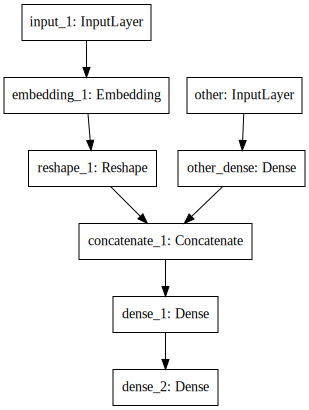

In [8]:
SVG(model_to_dot(emb_model).create(prog='dot', format='svg'))

In [9]:
nn_train_input = [X_train[cat_cols_coded[0]], X_train[other_cols]]
nn_test_input = [X_test[cat_cols_coded[0]], X_test[other_cols]]

In [10]:
emb_model = create_embedding_model()
emb_model_fitted = emb_model.fit(nn_train_input, y_train, batch_size=16, epochs=1)

Epoch 1/1
85000/85000 [==============================] - 6s 66us/step - loss: 0.1665


In [11]:
y_proba = emb_model.predict(nn_test_input)

treshold = 0.5
y_classes = (y_proba > treshold).flatten().astype('int32')

print(classification_report(y_test, y_classes, digits=4))

              precision    recall  f1-score   support

           0     0.9633    1.0000    0.9813     14449
           1     0.0000    0.0000    0.0000       551

   micro avg     0.9633    0.9633    0.9633     15000
   macro avg     0.4816    0.5000    0.4906     15000
weighted avg     0.9279    0.9633    0.9452     15000



/Users/marcel/anaconda3/envs/ML_Setup/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
